#Preperation

In [ ]:
!git clone #anonymous github

In [ ]:
!pip install transformers
!pip install wget
!pip install lime
!pip install glm-saga

In [ ]:
%cd MultiViz/structured-framework/

In [ ]:
!mkdir data
%cd data

In [ ]:
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip
 

In [ ]:
!unzip v2_Questions_Val_mscoco.zip
!unzip val2014.zip
!unzip v2_Annotations_Val_mscoco.zip

In [ ]:
%cd ../

In [34]:
!mkdir tmp
!mkdir visuals

#Define VQA_ViLT analysis model

Note: following the definition of the abstract analysis model definition in analysismodel.py to define the VQA_ViLT model

In [35]:
import matplotlib.pyplot as plt
import torch
import json
import torch.nn.functional as F
import numpy as np
import cv2
from copy import deepcopy
from transformers import ViltProcessor, ViltForQuestionAnswering

from models.analysismodel import analysismodel

import PIL
import random
from tqdm import tqdm

class VQAVILT:
    def __init__(self, device="cuda"):
        #super(analysismodel, self).__init__()
        self.device = device
   
        self.processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
        self.model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa").to(device)

        self.modalitynames = ["image", "text"]
        self.modalitytypes = ["image", "text"]

    def getmodalitynames(self):
      return self.modalitynames
    
    def getmodalitytypes(self):
      return self.modalitytypes

    def getunimodaldata(self, datainstance, modality):
        if modality == "image":
            return cv2.resize(np.asarray(PIL.Image.open(datainstance[0])), (224, 224))
        elif modality == "text":
            return datainstance[1]
        else:
            raise ValueError

    def getcorrectlabel(self, datainstance):
        return datainstance[-1]

    def forward(self, datainstance):
        with torch.no_grad():
            image_path, text = datainstance[0], datainstance[1]
            image = torch.as_tensor(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
            encoding = self.processor(image, text, return_tensors="pt").to(self.device)
            
            model_features = None

            def hook(module, input, output):
                nonlocal model_features
                model_feat = input[0][0].squeeze()
                model_features = model_feat

            handle = self.model.classifier[-1].register_forward_hook(
                hook
            )
            output_vqa = self.model(**encoding)

            handle.remove()
            assert model_features.shape[0] == 1536
            return output_vqa.logits[0], deepcopy(model_features)

    # in this case we don't do batching, so we just do one at a time:
    def forwardbatch(self, datainstances):
        outs = []
        for di in datainstances:
            outs.append(self.forward(di))
        return outs

    def getlogitsize(self):
        return 3129

    def getlogit(self, resultobj):
        return resultobj[0]

    def getprelinear(self, resultobj):
        return resultobj[1]

    def getpredlabel(self, resultobj):
        return resultobj[0].argmax(-1).item()

    def getprelinearsize(self):
        return 1536

    def replaceunimodaldata(self, datainstance, modality, newinput):
        if modality == "image":
            randname = "tmp/vqa" + str(random.randint(0, 100000000)) + ".jpg"
            plt.imsave(randname, newinput)
            return randname, datainstance[1], datainstance[2], datainstance[3]
        elif modality == "text":
            return datainstance[0], newinput, datainstance[2], datainstance[3]
        else:
            raise ValueError

    def getgrad(self, datainstance, target):
        im = PIL.Image.open(datainstance[0])
        sentence = datainstance[1]
        inputs = self.processor(
            text=sentence,
            images=im,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
        )
        for k, v in inputs.items():
            inputs[k] = v.to(self.device)
        inputs.pixel_values.requires_grad = True
        outputs = self.model(**inputs)
        outputs.logits[0][target].backward()
        return [inputs.pixel_values.detach()[0]], [inputs.pixel_values.grad.detach()[0]]

    def getgradtext(self, datainstance, target_idx, alltarget=False, prelinear=False):
        self.model.zero_grad()
        im = PIL.Image.open(datainstance[0])
        sentences = [datainstance[1]]
        inputs = self.processor(
            text=sentences,
            images=im,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
        )

        text_embedding = None
        text_ids = None
        text_grad = None

        def hook_forward(module, input, output):
            nonlocal text_embedding, text_ids
            text_embedding = output[0]
            text_ids = input[0]

        def hook_backward(module, input, output):
            nonlocal text_grad
            text_grad = output[0][0]

        forward_handle = self.model.vilt.embeddings.text_embeddings.word_embeddings.register_forward_hook(
            hook_forward
        )
        backward_handle = self.model.vilt.embeddings.text_embeddings.word_embeddings.register_backward_hook(
            hook_backward
        )

        for k, v in inputs.items():
            inputs[k] = v.to(self.device)

        inputs.pixel_values.requires_grad = True

        outputs = self.model(**inputs)

        probas = outputs.logits
        if alltarget:
            torch.sum(probas[0]).backward(create_graph=True)
        else:
            probas[0][target_idx].backward()

        forward_handle.remove()
        backward_handle.remove()

        res = torch.sum(text_embedding * text_grad, dim=1)

        return res, parse(sentences[0]), inputs.pixel_values, text_ids

    def getdoublegrad(self, datainstance, target, targetwords, alltarget=True):

        res, di, normed_image, text_ids = self.getgradtext(
            datainstance, target, alltarget=alltarget
        )
        ac = 0.0
        for id in targetwords:
            ac += torch.abs(res[id])

        rets = torch.autograd.grad(ac, normed_image)
        return rets[0], di, text_ids

    # TODO: If this is correct
    def private_prep(self, datainstance):
        with torch.no_grad():
            im = PIL.Image.open(datainstance[0])
            sentence = datainstance[1][self.target_idx]
            inputs = self.processor(
                text=sentence,
                images=im,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
            )
        return inputs


def parse(sent):
    words = []
    for word in sent[:-1].split(" "):
        words.append(word)
    words.append("<end>")
    words.insert(0, "<start>")
    return words

#VQA_VilT analysis

In [36]:
import PIL.Image as Image

from datasets.vqa import VQADataset
from visualizations.visualizelime import visualizelime

from analysis.emap import emap_print_report
from analysis.dime import dime
from analysis.unimodallime import rununimodallime
from visualizations.visualizegradient import*

In [37]:
#processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
#model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

datas = VQADataset("val")
analysismodel = VQAVILT()

###Gradient-based


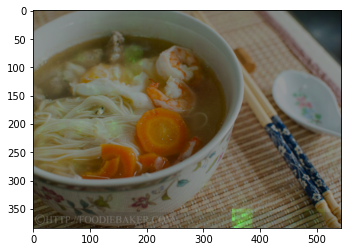

In [38]:
# define a wrapper for visualizing saliency map using our visualization
# functions from visualizations.visualizegradient
def generate_grad(dataset, model, idx, target, image_out, text_out, prelinear=False):
    data_instance = dataset.getdata(idx)
    imgfile = data_instance[0]

    #calculate gradient
    _, grad = model.getgrad(data_instance, target)
    grad = torch.unsqueeze(grad[0], dim=0)

    #visualize
    grads = torch.sum(torch.abs(grad).squeeze(), dim=0)
    t = normalize255(grads)
    heatmap2d(t, image_out, imgfile)  

idx = 5
target = 3
generate_grad(datas, analysismodel, idx, target, f"visuals/vqa-vilt-{idx}-image-grad-{target}.png", f"visuals/vqa-vilt-{idx}-image-grad-{target}.png")




###Unimodal Lime

In [39]:
# pick data instance you want to explain
instance = datas.getdata(554)
# get the model predicted label
predlabel = analysismodel.getpredlabel(analysismodel.forward(instance))
# get the correct label
correctlabel = analysismodel.getcorrectlabel(instance)
# generate lime explanation for image modality on both correct label and predicted label
explanation1 = rununimodallime(
    instance, "image", "image", analysismodel, (predlabel, correctlabel)
)
# generate lime explanation for text modality on both correct label and predicted label
explanation2 = rununimodallime(
    instance,
    "text",
    "text",
    analysismodel,
    (predlabel, correctlabel),
    class_names=datas.classnames(),
)
# visualize explanations and save to directory
visualizelime(
    explanation1, "image", predlabel, "visuals/vqa-vilt-554-image-lime-pred.png"
)
visualizelime(
    explanation1, "image", correctlabel, "visuals/vqa-vilt-554-image-lime-correct.png"
)
visualizelime(
    explanation2, "text", predlabel, "visuals/vqa-vilt-554-text-lime-pred.png"
)
visualizelime(
    explanation2, "text", correctlabel, "visuals/vqa-vilt-554-text-lime-correct.png"
)

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

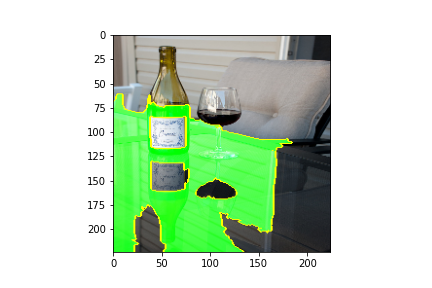

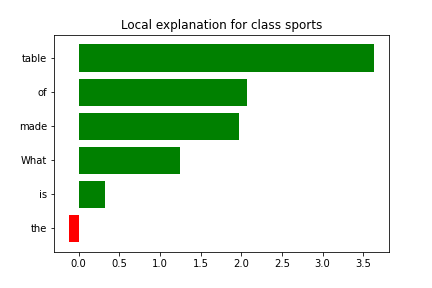

In [40]:
display(Image.open("visuals/vqa-vilt-554-image-lime-pred.png"))
display(Image.open("visuals/vqa-vilt-554-text-lime-pred.png"))

###DIME

In [41]:
# pick data instance you want to explain
instance = datas.getdata(554)
# get the model predicted label
predlabel = analysismodel.getpredlabel(analysismodel.forward(instance))
# get the correct label
correctlabel = analysismodel.getcorrectlabel(instance)
# run dime
instances = []

for i in range(100):
    instances.append(datas.getdata(i * 50 + 4))

explanations = dime(
    instances, 11, analysismodel, [predlabel, correctlabel]
)

# visualize explanations and save to directory
visualizelime(
    explanations[0], "image", 0, "visuals/vqa-vilt-554-image-dime-pred-uni.png"
)
visualizelime(
    explanations[0], "image", 2, "visuals/vqa-vilt-554-image-dime-correct-uni.png"
)
visualizelime(
    explanations[0], "image", 1, "visuals/vqa-vilt-554-image-dime-pred-multi.png"
)
visualizelime(
    explanations[0], "image", 3, "visuals/vqa-vilt-554-image-dime-correct-multi.png"
)
visualizelime(
    explanations[1], "text", 0, "visuals/vqa-vilt-554-text-dime-pred-uni.png"
)
visualizelime(
    explanations[1], "text", 2, "visuals/vqa-vilt-554-text-lime-correct-uni.png"
)
visualizelime(
    explanations[1], "text", 1, "visuals/vqa-vilt-554-text-dime-pred-multi.png"
)
visualizelime(
    explanations[1], "text", 3, "visuals/vqa-vilt-554-text-lime-correct-multi.png"
)

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

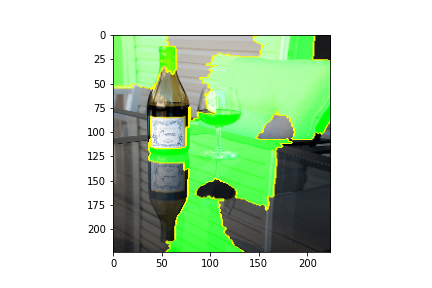

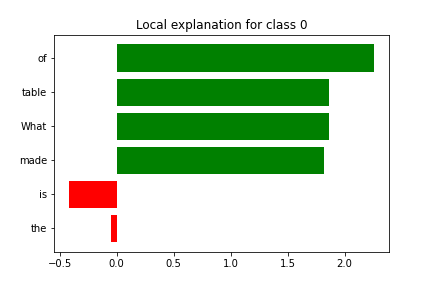

In [42]:
display(Image.open("visuals/vqa-vilt-554-image-dime-pred-uni.png"))
display(Image.open("visuals/vqa-vilt-554-text-dime-pred-uni.png"))